## Import packages

In [19]:
import scanpy as sc
import os,sys
import pandas as pd
import anndata
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sc.settings.set_figure_params(dpi=80)
import matplotlib as mpl
from pym3c.adata import plot_cluster
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

## Parameters

In [20]:
param_yaml=None
level=1
rootdir="~/Projects/mouse_pfc/clustering/100kb"
parent_ct=None
obs_cols=['Age',"mCGFrac","mCHFrac"]
mc_types = ['CGN','CHN']
feature_type='CEF'
clustering_name_annot = "CellClass" #
min_cluster_size=50
coord_base = "tsne" #tsne, umap
use_rep="X_scVI" # X_pca

# marker genes
marker_path="~/Projects/BICAN/metadata/Markers.xlsx"
marker_sheet = 'BICAN'
marker_level = None
max_depth = None
species='human'

# gene scores
score_key = "gene-CHN"
palette_path=None
kernel_name='m3c'

In [21]:
# Parameters
level = 2
parent_ct = "Splatter"
obs_cols = ["Region", "donor", "tech", "MajorType", "mCGFrac", "mCHFrac", "leiden"]
rootdir = "/home/x-wding2/Projects/BG/clustering/100kb"
metadata_path = "/home/x-wding2/Projects/BG/metadata/BG_metadata.tsv.gz"
mc_types = ["CGN", "CHN"]
pca_downsample = 100000
use_lsi = False
clip_norm_value = 10
max_value = None
with_mean = False
batch_col = ["Study", "tech", "donor"]
batch_correct_method = "harmony"
categorical_covariate_keys = None
n_layers = 1
std_cutoff = None
adata_path = ["~/Projects/BG/adata/BG.100kb-CGN.h5ad", "~/Projects/BG/adata/BG.100kb-CHN.h5ad"]
exclude_adata = None
gene_adata_path = "/home/x-wding2/Projects/BG/adata/BG.gene-C*N.h5ad"
exclude_gene_adata = None
cef_downsample = 500
top_n_enriched_features = 200
feature_type = "CEF"
alpha = 0.05
max_cell_prop = None
p_cutoff = 0.1
coord_base = "umap"
use_rep = "X_pca_harmony"
n_neighbors = None
metric = "euclidean"
min_cluster_size = 50
leiden_repeats = 200
leiden_resolution = 0.5
consensus_rate = 0.5
train_frac = 0.5
train_max_n = 1000
random_state = 0
max_iter = 50
n_jobs = 24
target_accuracy = 0.9
cor_method = "pearson"
linkage_method = "average"
marker_path = "/home/x-wding2/Projects/BG/metadata/BG_markers.xlsx"
marker_sheet = "BG"
marker_level = None
max_depth = None
palette_path = "/home/x-wding2/Projects/BG/metadata/BG_color_palette.xlsx"
clustering_name_annot = "Subclass"
final_mc_read_col = "UniqueAlignFinalReads"
score_key = "BG.gene-CHN"
param_yaml = "/home/x-wding2/Projects/Github/pym3c/pym3c/notebooks/clustering/BG_100kb.yaml"
kernel_name = "m3c"


In [22]:
rootdir=os.path.abspath(os.path.expanduser(rootdir))
assert os.path.exists(os.path.abspath(os.path.expanduser(rootdir)))
clustering_name=f"L{level}"
if not os.path.exists(os.path.join(rootdir,"obs_with_cluster_id.tsv")):
    run_clustering=True
    cluster_col=clustering_name
else:
    run_clustering=False #cluster_id is already existed in obs_with_cluster_id.tsv (iterative clustering is done)
    cluster_col='cluster_id'
if level == 1 or os.path.exists(os.path.join(rootdir,"obs_with_cluster_id.tsv")):
    run_annotation=True #added cell type scores using given marker genes
else:
    run_annotation=False # didn't calculate cell type score, only defined the cluster (iterative clustering)
outdir=os.path.join(rootdir,clustering_name)
outdir=os.path.abspath(os.path.expanduser(outdir))
assert os.path.exists(outdir)
figdir=os.path.join(outdir,"figures")
datadir=os.path.join(outdir,"data")
assert os.path.exists(figdir)
assert os.path.exists(datadir)

if parent_ct is None: # the first level
    data_basename=os.path.join(datadir,f"{clustering_name}")
    fig_basename=os.path.join(figdir,f"{clustering_name}")
else:
    bname=f"{clustering_name}_{parent_ct}"
    data_basename=os.path.join(datadir,bname.replace(' ','_'))
    fig_basename=os.path.join(figdir,bname.replace(' ','_'))
basis=f"X_{coord_base}"
print(run_clustering,run_annotation)

False True


## Load adata

In [23]:
if run_annotation:
    input_adata=output_adata=f'{data_basename}.ConsensusClustering.WithScores.adata.h5ad'
else:
    input_adata=f'{data_basename}.ConsensusClustering.adata.h5ad'
print(input_adata)
adata=anndata.read_h5ad(input_adata)
if cluster_col=='cluster_id':
    df_obs=pd.read_csv(os.path.join(rootdir,"obs_with_cluster_id.tsv"),sep='\t',index_col=0)
    D=df_obs[cluster_col].to_dict()
    adata.obs[cluster_col]=adata.obs_names.map(D)
    if clustering_name_annot in df_obs.columns.tolist():
        D=df_obs[clustering_name_annot].to_dict()
        adata.obs[clustering_name_annot]=adata.obs_names.map(D)
    use_cells=list(set(adata.obs_names.tolist()) & set(df_obs.index.tolist()))
    adata=adata[use_cells,:] # some doublet cells were removed during the collection of cluster_id
adata

/home/x-wding2/Projects/BG/clustering/100kb/L2/data/L2_Splatter.ConsensusClustering.WithScores.adata.h5ad


View of AnnData object with n_obs × n_vars = 25409 × 1
    obs: 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'R1UniqueMappedReads', 'R1MultiMappedReads', 'R1UniqueMappingRate', 'R1MultiMappingRate', 'R1OverallMappingRate', 'R2UniqueMappedReads', 'R2MultiMappedReads', 'R2UniqueMappingRate', 'R2MultiMappingRate', 'R2OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericContacts', 'NoContacts', 'MappedFragments', 'DeduppedContacts', 'ContactsDeduplicationRate', 'TotalCisContacts', 'TotalTransContacts', 'TotalMultiContacts', 'CisContactsRatio', 'Tra

In [24]:
# load cell type labels transferred from HMBA
df=pd.read_csv(os.path.expanduser("~/Projects/BG/annotations/cell_type_mapper/cell_annotations.tsv"),index_col=0,sep='\t')
adata.obs['Subclass_HMBA']=adata.obs_names.map(df['Subclass'].to_dict())

In [ ]:
# adata.obs['L2']=adata.obs['cluster_id'].apply(lambda x:"+".join(x.split('+')[:2]))
# adata.obs['L3']=adata.obs['cluster_id'].apply(lambda x:"+".join(x.split('+')[:3]))
# adata.obs['L3']=adata.obs['cluster_id'].apply(lambda x:"+".join(x.split('+')[:3]))
plt.figure()
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata,basis=basis,color=['leiden','L1','L2','MajorType',clustering_name_annot+'_HMBA'],
               wspace=0.25,ncols=2,show=False,
               legend_loc='on data',use_raw=False,
               vmin='p5',vmax='p95',
               cmap='jet' #vcenter='p50'
              )
# plt.savefig(f"{fig_basename}.{coord_base}.obs_cols.pdf",bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
colors=pd.read_excel(os.path.expanduser("/home/x-wding2/Projects/BICAN/adata/HMBA_v2/HMBA_color_palette.xlsx"),
                     sheet_name=clustering_name_annot,index_col=0).Hex.to_dict()
plot_cluster(adata_path=adata,coord_base='umap',cluster_col=clustering_name_annot+'_HMBA',coding=True,fontsize=3,
             output=f"{fig_basename}.annotated.umap.infer.pdf",palette_path=colors,ncol=1)

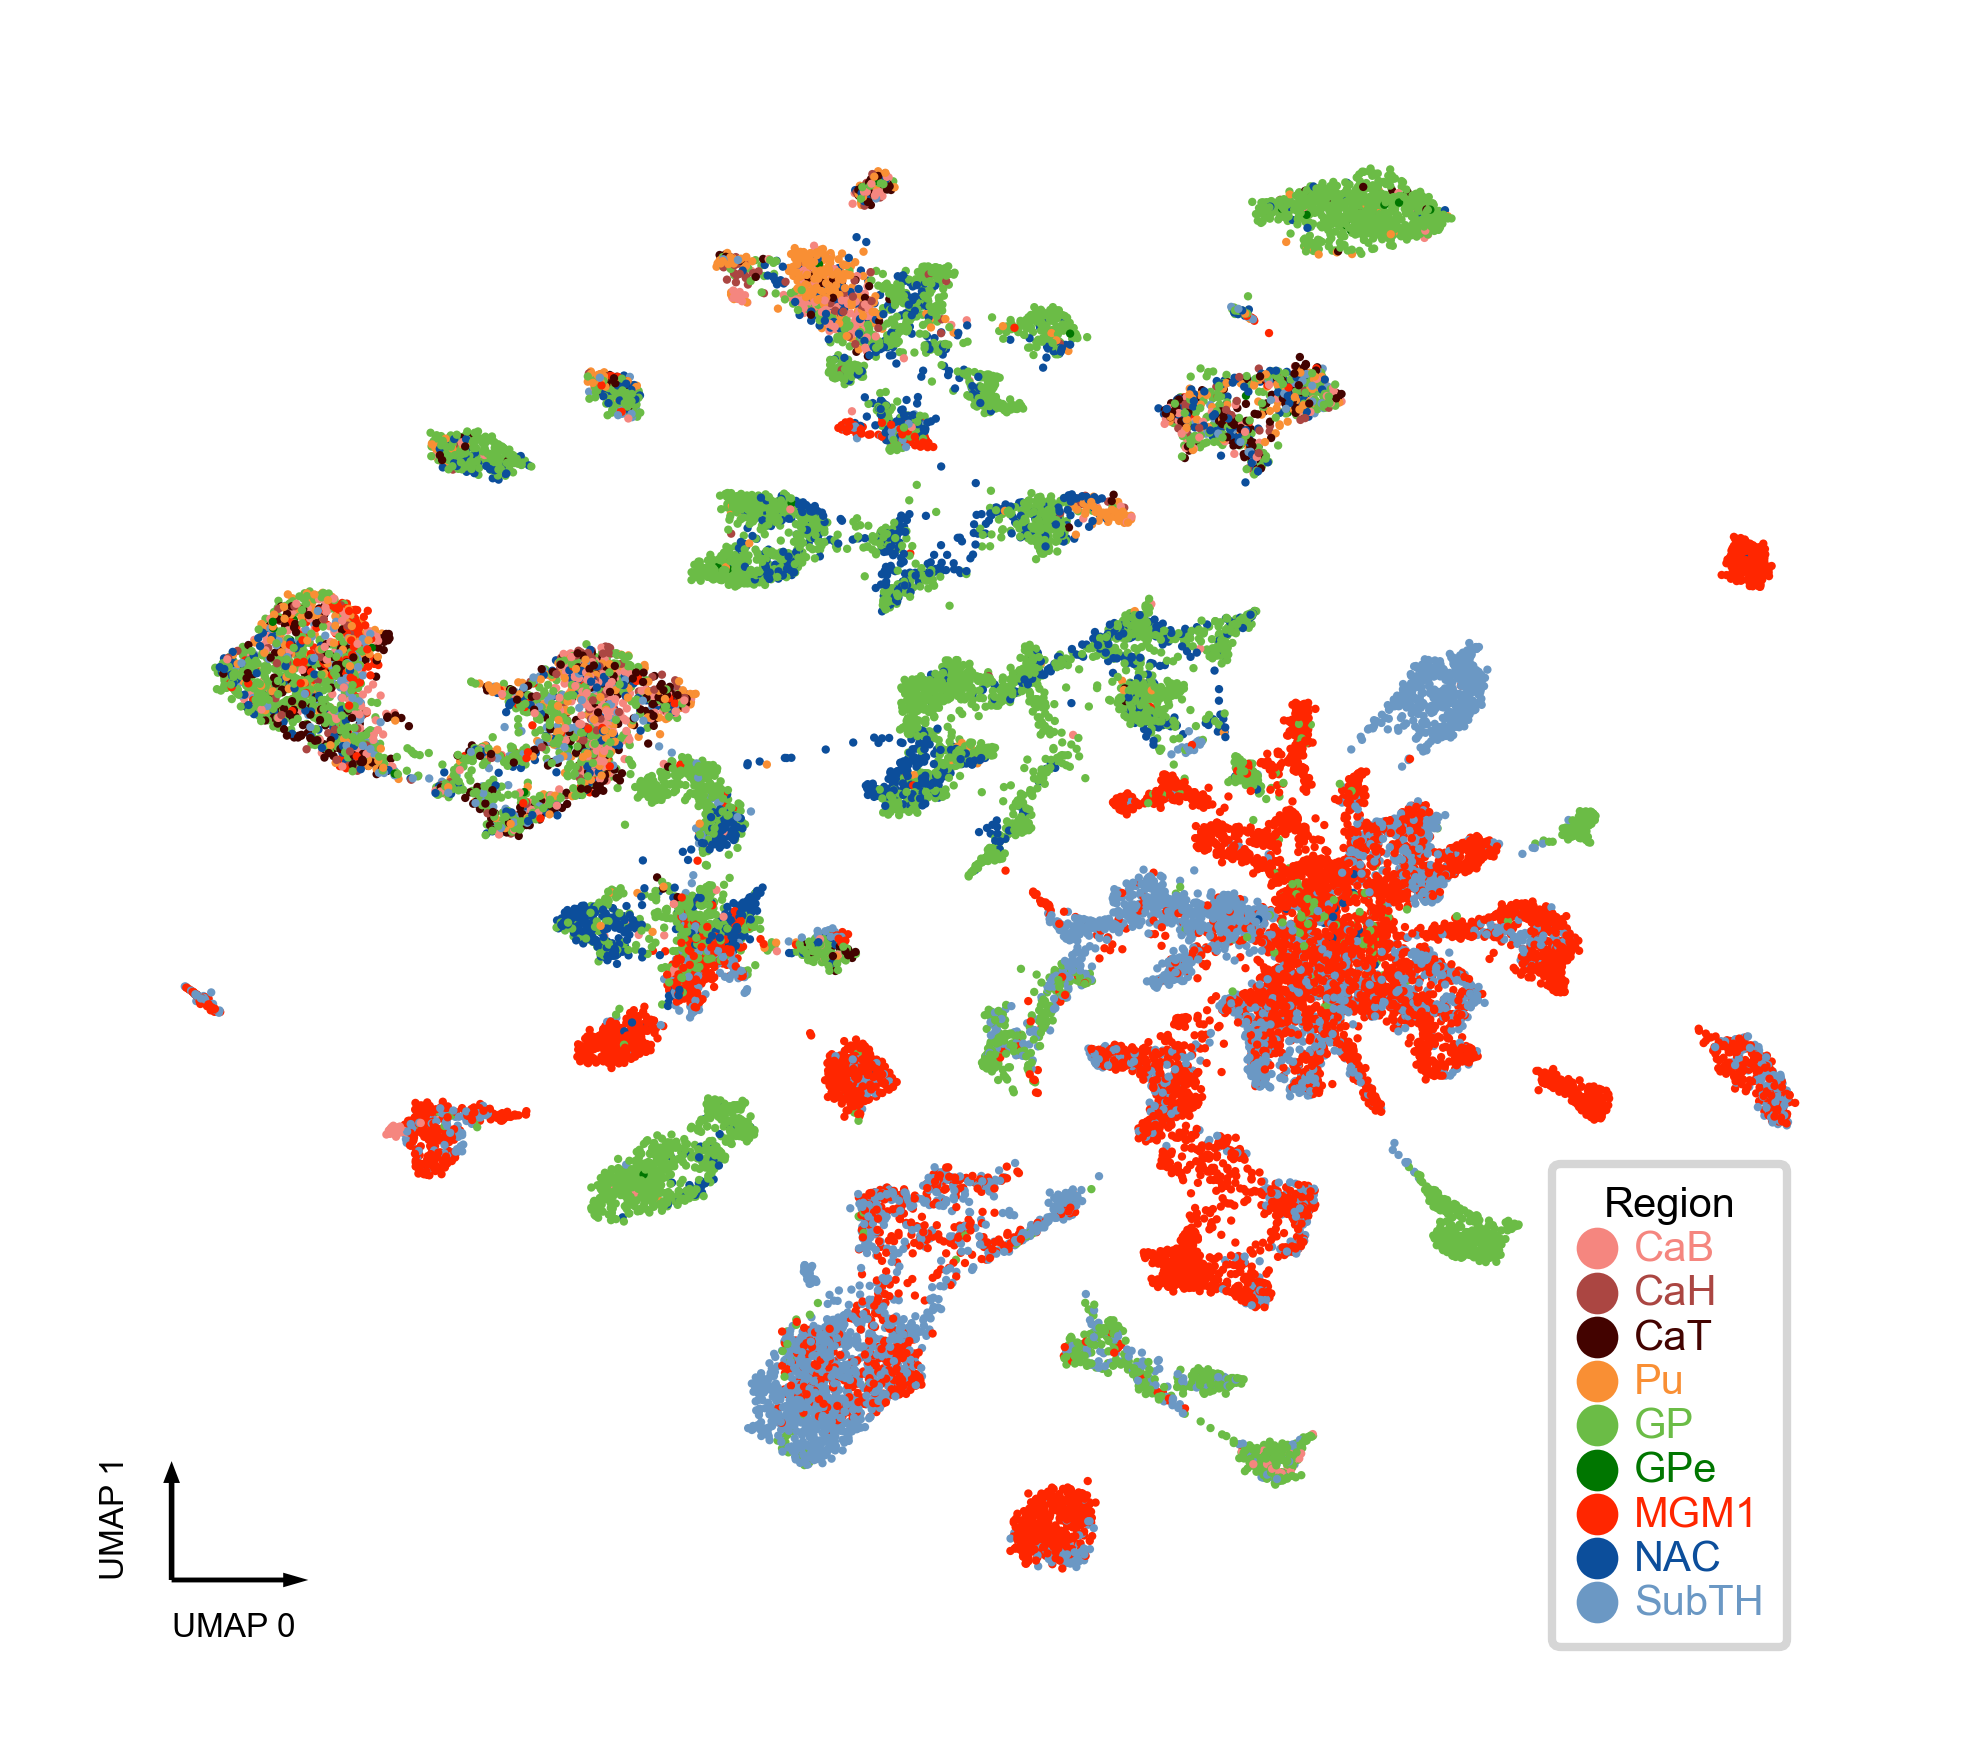

In [11]:
plot_cluster(adata_path=adata,coord_base='umap',cluster_col='Region',coding=False,text_anno=None,
             output=f"{fig_basename}.annotated.umap.Region.pdf",palette_path=palette_path,ncol=1,
             legend_kws=dict(bbox_to_anchor=(0.8,0.32)),
            )

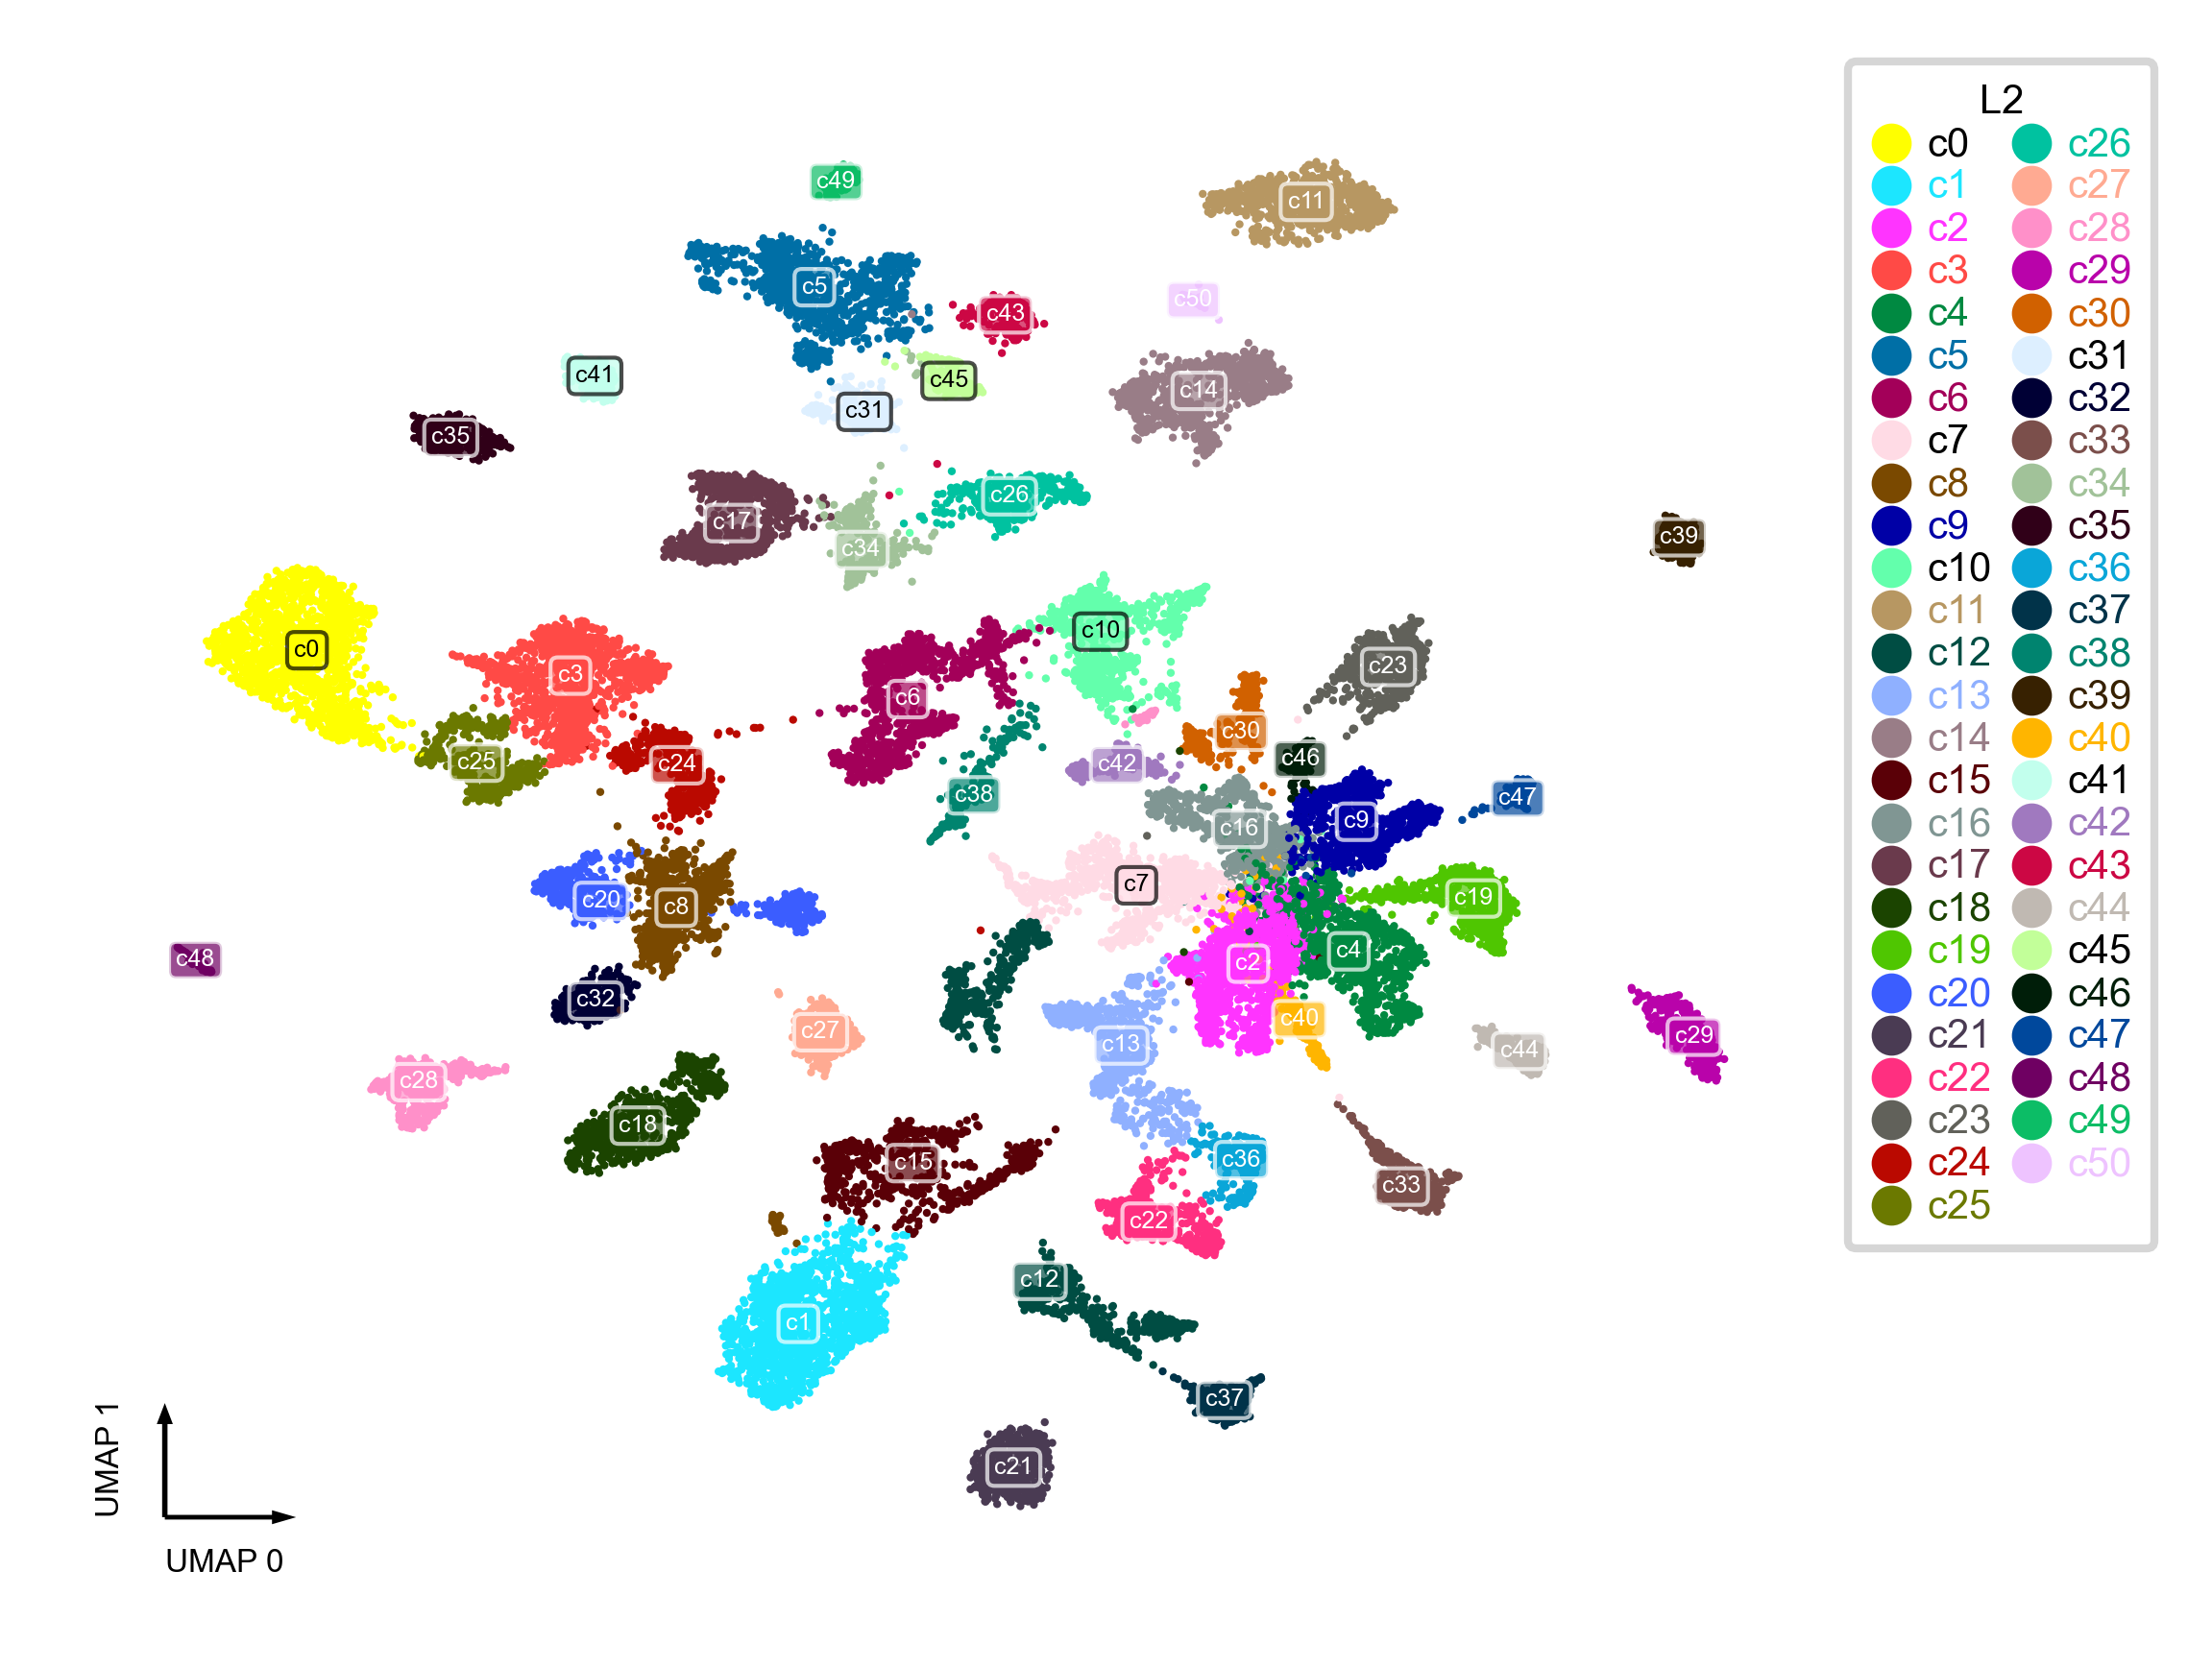

In [12]:
plot_cluster(adata_path=adata,coord_base='umap',cluster_col='L2',
    coding=False,fontsize=3,output=f"{fig_basename}.annotated.umap.L2.pdf",
    palette_path=None,ncol=2)

## Manually Cell Type Mapping

In [26]:
print([col.replace('_score','') for col in adata.obs.columns if col.endswith('_score')])

['Nonneuron', 'Glut', 'Subpallium GABA', 'CN VIP GABA', 'CN LAMP5-CXCL14 GABA', 'CN LAMP5-LHX6 GABA', 'F M GATA3 GABA', 'F Glut', 'CN MEIS2 GABA', 'CN LHX8 GABA', 'CN Cholinergic GABA', 'SN PAX7 GABA', 'M Dopa', 'STR RSPO2 GABA', 'STR SST-CHODL GABA', 'STR SST GABA', 'F M Glut', 'F GABA', 'CN ONECUT1 GABA']


In [27]:
# L2: consensus clustering
ct_mapping={'CN Cholinergic GABA': [26], 'CN GABA-Glut': [47], 
            'CN LAMP5-CXCL14 GABA': [0], 'CN LAMP5-LHX6 GABA': [41, 50], 
            'CN LHX8 GABA': [17, 34], 'CN MEIS2 GABA': [11, 45], 
            'CN ONECUT1 GABA': [33], 'CN ST18 GABA': [43], 
            'CN VIP GABA': [3, 25], 'F GABA': [6, 7, 8, 10, 12, 20, 23, 24, 31, 35, 37, 48], 
            'F Glut': [1, 18], 'F M GATA3 GABA': [9, 16, 29, 40, 44], 
            'F M Glut': [2, 4, 13, 15, 19, 21, 27, 28, 32, 38, 39, 46], 
            'M Dopa': [22, 36], 'SN PAX7 GABA': [30, 42], 
            # 'STR D2 MSN': [35], 
            'STR RSPO2 GABA': [14], 
            'STR SST-CHODL GABA': [5, 49]}

In [28]:
CTMD={}
for ct in ct_mapping:
    for cluster in ct_mapping[ct]:
        if cluster not in CTMD:
            CTMD[cluster]=ct
        else:
            CTMD[cluster]=CTMD[cluster]+','+ct
# adata.obs[clustering_name_annot]=adata.obs[clustering_name].map(CTMD)
adata.obs[clustering_name_annot]=adata.obs[clustering_name].cat.codes.map(CTMD)
# adata.obs.loc[adata.obs[clustering_name].isin(doublet_percent[doublet_percent>=50].index.tolist()),clustering_name_annot]='Low quality cells'
adata.obs[clustering_name_annot].fillna('Unk',inplace=True)
# adata.obs.loc[adata.obs['leiden']=='15',clustering_name_annot]='STR RSPO2 GABA'
adata.strings_to_categoricals()
adata.obs[clustering_name_annot].value_counts()

Subclass
F GABA                  6431
F M Glut                6059
F M GATA3 GABA          2129
F Glut                  1897
CN VIP GABA             1537
CN LAMP5-CXCL14 GABA    1315
STR SST-CHODL GABA      1117
CN MEIS2 GABA            920
CN LHX8 GABA             893
STR RSPO2 GABA           685
M Dopa                   674
SN PAX7 GABA             522
CN Cholinergic GABA      360
CN ONECUT1 GABA          287
CN LAMP5-LHX6 GABA       263
CN ST18 GABA             198
CN GABA-Glut             122
Name: count, dtype: int64

In [29]:
# cluster_id
# ct_mapping={
#             'CN Cholinergic GABA': [170, 171, 172, 173], 
#             'CN GABA-Glut': [107], 'CN LAMP5-CXCL14 GABA': [143, 144, 145, 146, 147, 148, 149, 150, 151, 152], 
#             'CN LAMP5-LHX6 GABA': [156, 157], 'CN LHX8 GABA': [114, 166, 167, 168, 169, 182, 183, 184, 188], 
#             'CN MEIS2 GABA': [205, 206, 207, 208, 209, 210, 211], 
#             'CN ONECUT1 GABA': [121, 122, 123], 'CN ST18 GABA': [186, 187], 
#             'CN VIP GABA': [137, 138, 139, 140, 141, 142, 153, 154, 155, 158, 159, 160, 161], 
#             'F GABA': [0,1, 2, 3, 4, 5, 6, 7, 8,9, 11, 12, 13, 14, 15, 22, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,54, 55, 56, 57, 58,59, 61, 111, 119,120,124,125, 126, 134,136, 212,217,219,227], 
#             'F Glut': [79, 80, 81, 82, 83, 84, 85, 110, 112, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], 
#             'F M GATA3 GABA': [18, 21, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 91, 92, 94, 95, 96, 113, 115, 116, 117, 118, 132, 133, 135], 
#             'F M Glut': [16, 17, 19, 20, 23, 24, 25, 26, 27, 28, 30, 63, 64, 65, 67, 69, 70, 86, 87, 88, 89, 90, 93, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 213, 214, 215, 216, 218, 220, 221, 222, 223, 224, 225, 226], 
#             'M Dopa': [66, 68, 71, 72, 73, 74, 75, 76, 77, 78], 
#             'OT Granular GABA': [60, 62], 'SN PAX7 GABA': [109, 130, 131, 228], 'STR D2 MSN': [127, 128, 129], 
#             'STR RSPO2 GABA': [174, 175, 176, 177, 178, 179, 180, 181], 
#             'STR SST GABA': [10], 'STR SST-CHODL GABA': [162, 163, 164, 165, 185, 189]}
# # Unk: 12

In [30]:
# CTMD={}
# for ct in ct_mapping:
#     for cluster in ct_mapping[ct]:
#         if cluster not in CTMD:
#             CTMD[cluster]=ct
#         else:
#             CTMD[cluster]=CTMD[cluster]+','+ct
# # adata.obs[clustering_name_annot]=adata.obs[clustering_name].map(CTMD)
# adata.obs[clustering_name_annot]=adata.obs['cluster_id'].cat.codes.map(CTMD)
# # adata.obs.loc[adata.obs[clustering_name].isin(doublet_percent[doublet_percent>=50].index.tolist()),clustering_name_annot]='Low quality cells'
# adata.obs[clustering_name_annot].fillna('Unk',inplace=True)
# adata.obs.loc[adata.obs['leiden']=='15',clustering_name_annot]='STR RSPO2 GABA'
# adata.strings_to_categoricals()
# adata.obs[clustering_name_annot].value_counts()

### Plot cell types

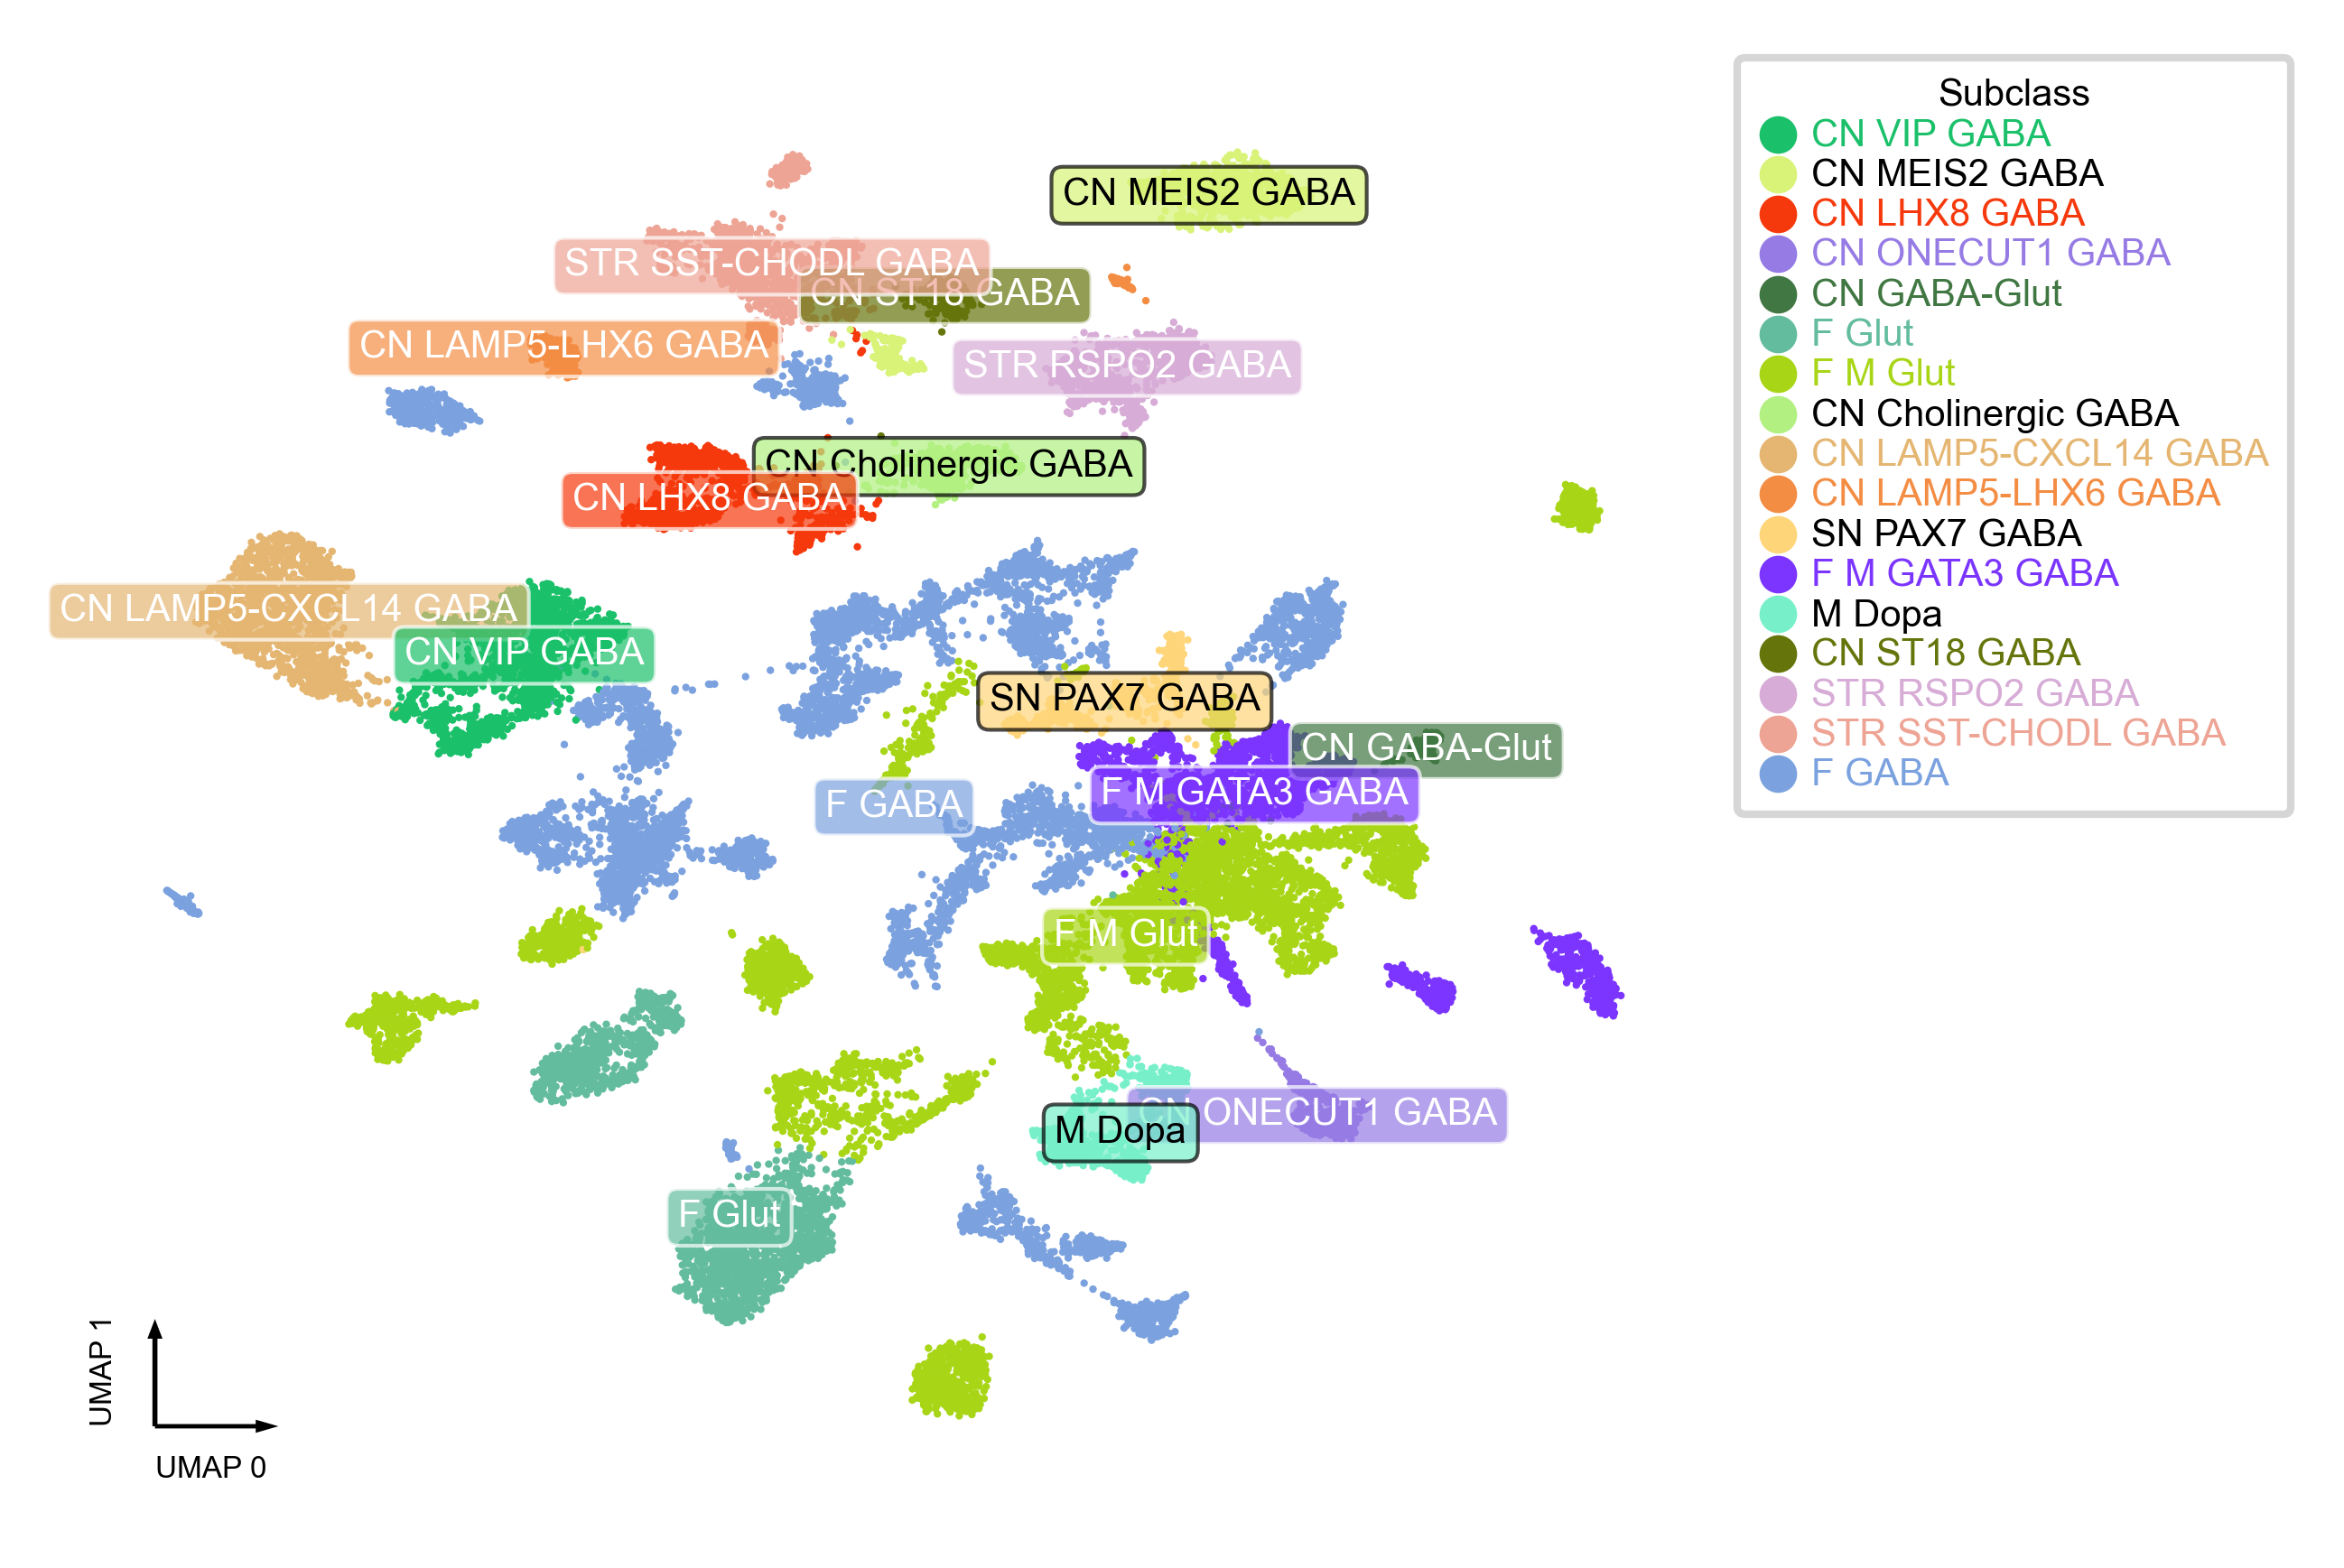

In [31]:
# colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name=clustering_name_annot,index_col=0).Hex.to_dict()
# colors['Mix']='gray'
plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col=clustering_name_annot,
             coding=False,palette_path=palette_path,ncol=1,
             output=f"{fig_basename}.annotated.{coord_base}.{clustering_name_annot}.pdf")
             #text_anno=None, outline=clustering_name_annot, outline_kws = {"linewidth": 0.5,"palette": colors, "c": "lightgray","single_contour_pad": 0.1},

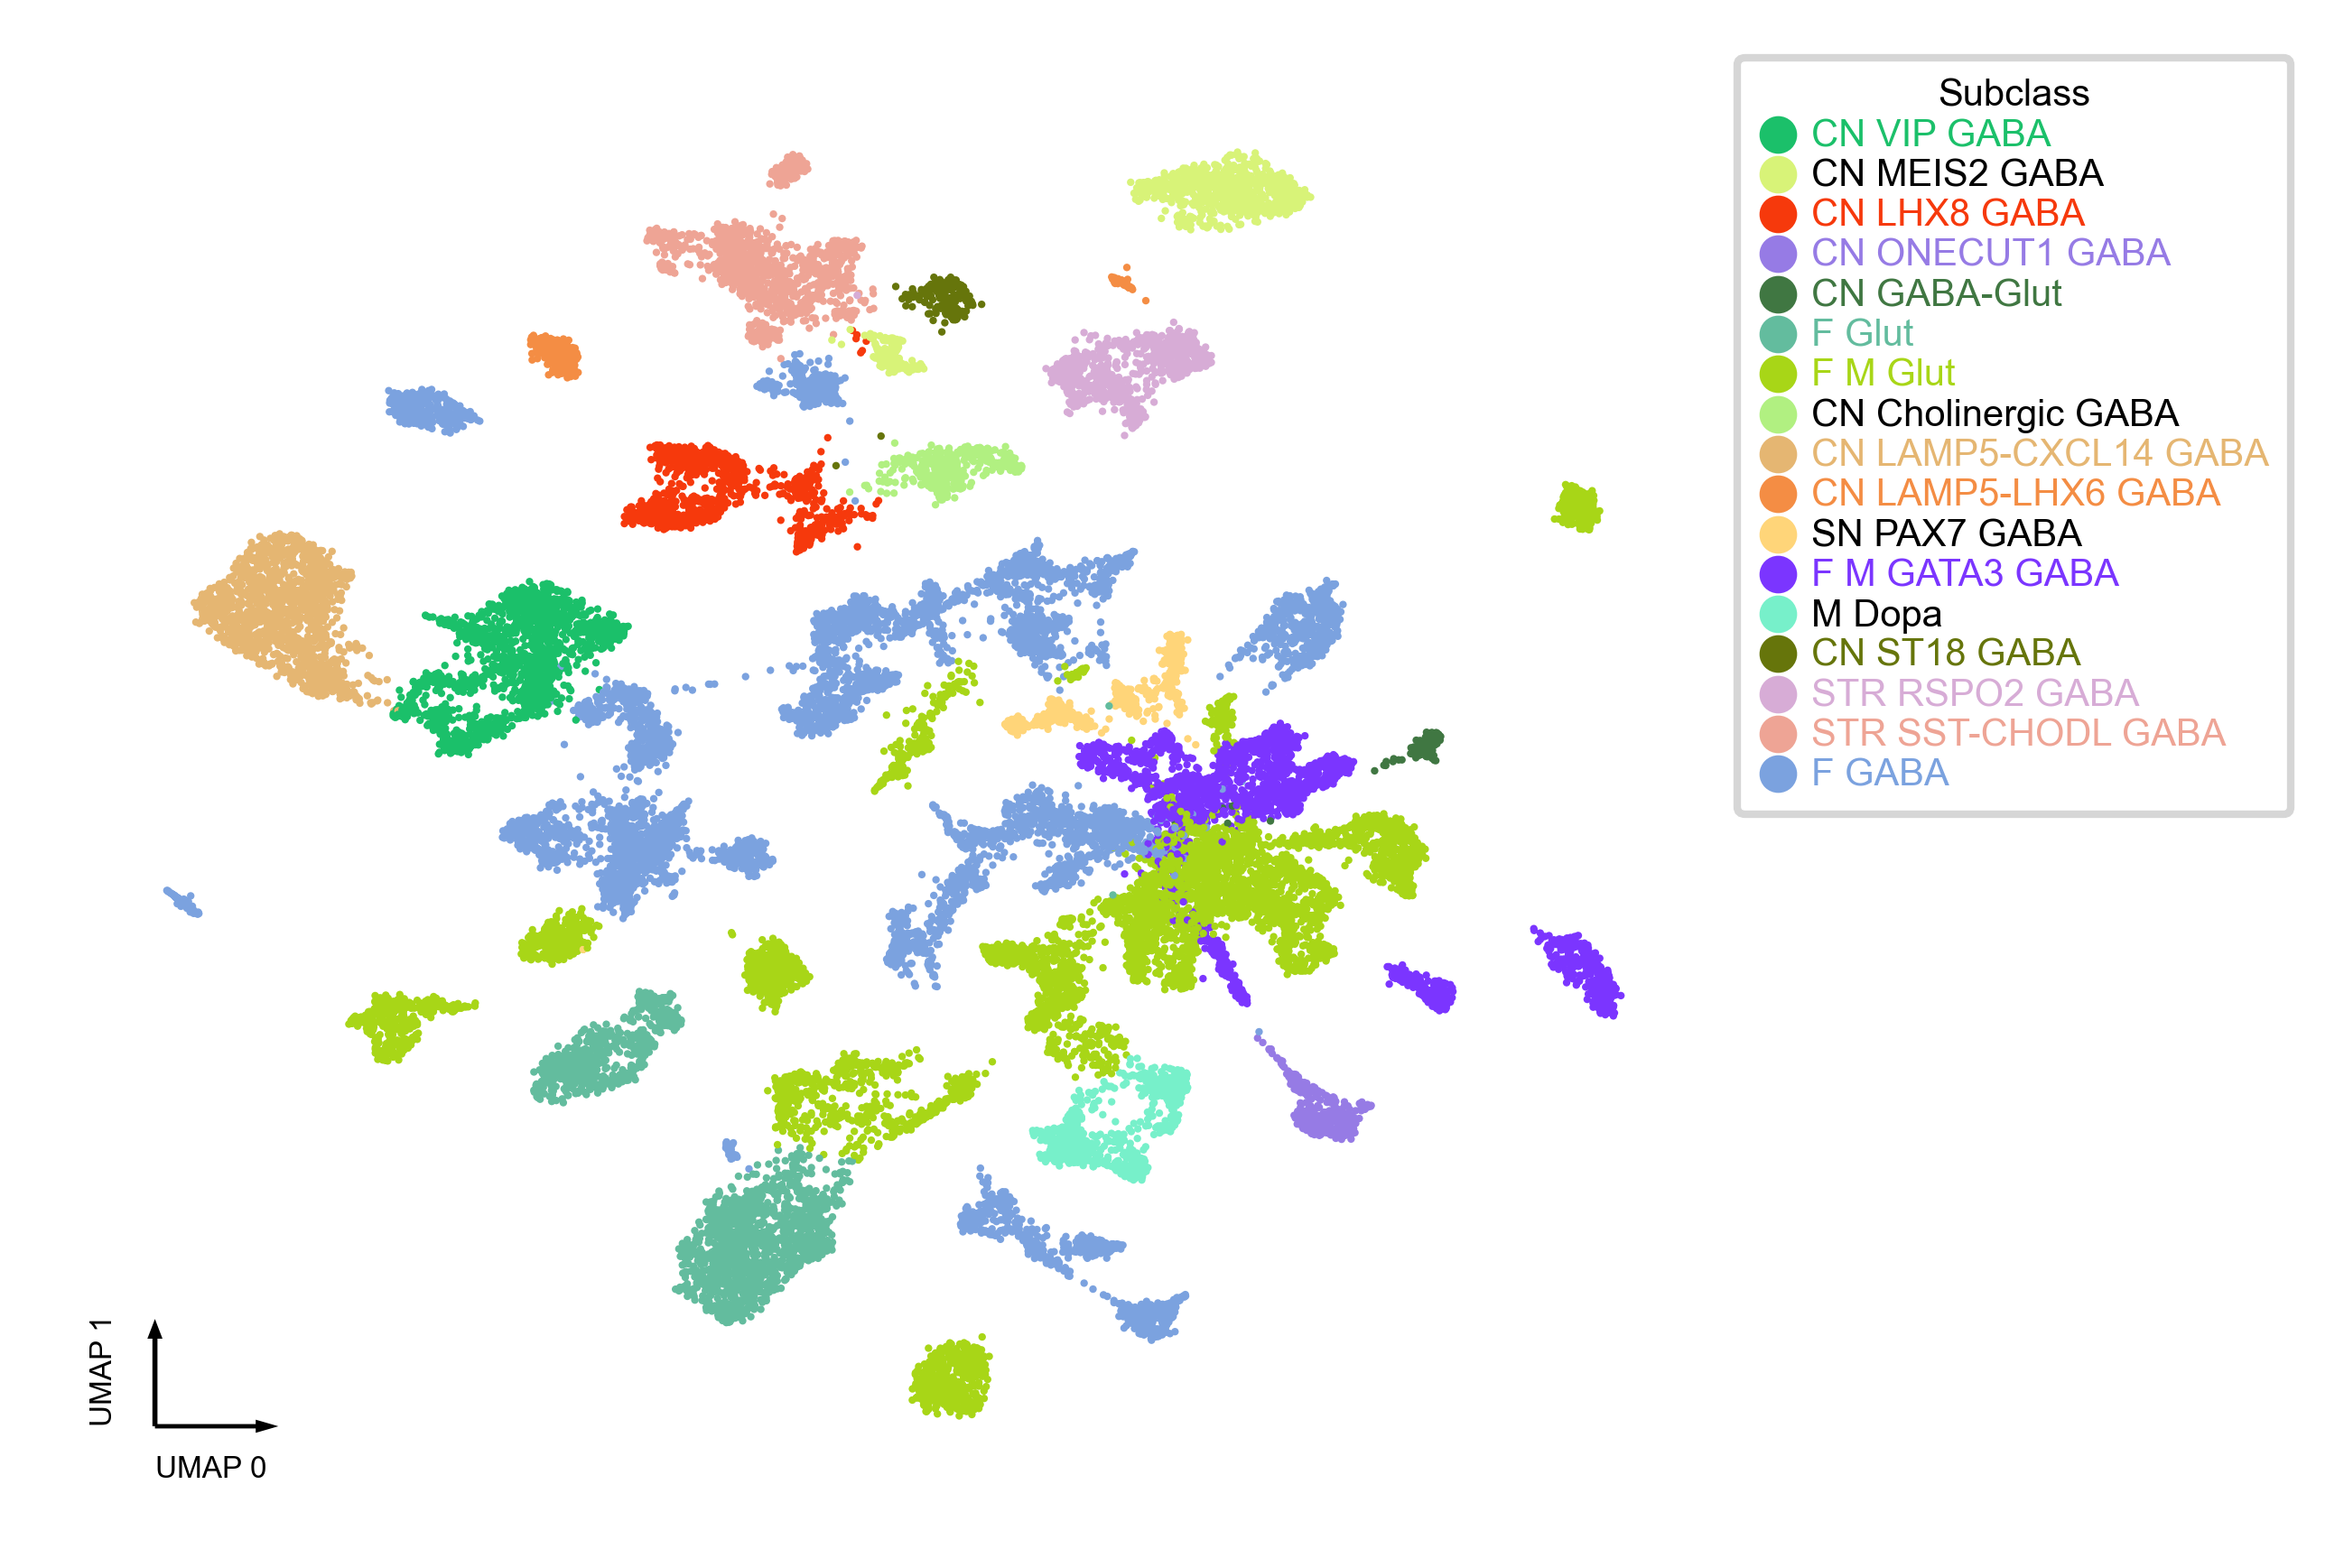

In [32]:
# colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name=clustering_name_annot,index_col=0).Hex.to_dict()
# colors['Mix']='gray'
plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col=clustering_name_annot,
             coding=False,palette_path=palette_path,text_anno=None,ncol=1,
             output=f"{fig_basename}.annotated.{coord_base}.{clustering_name_annot}_no_text.pdf"
            )
             # outline=clustering_name_annot, outline_kws = {"linewidth": 0.5,"palette": colors, "c": "lightgray","single_contour_pad": 0.1},

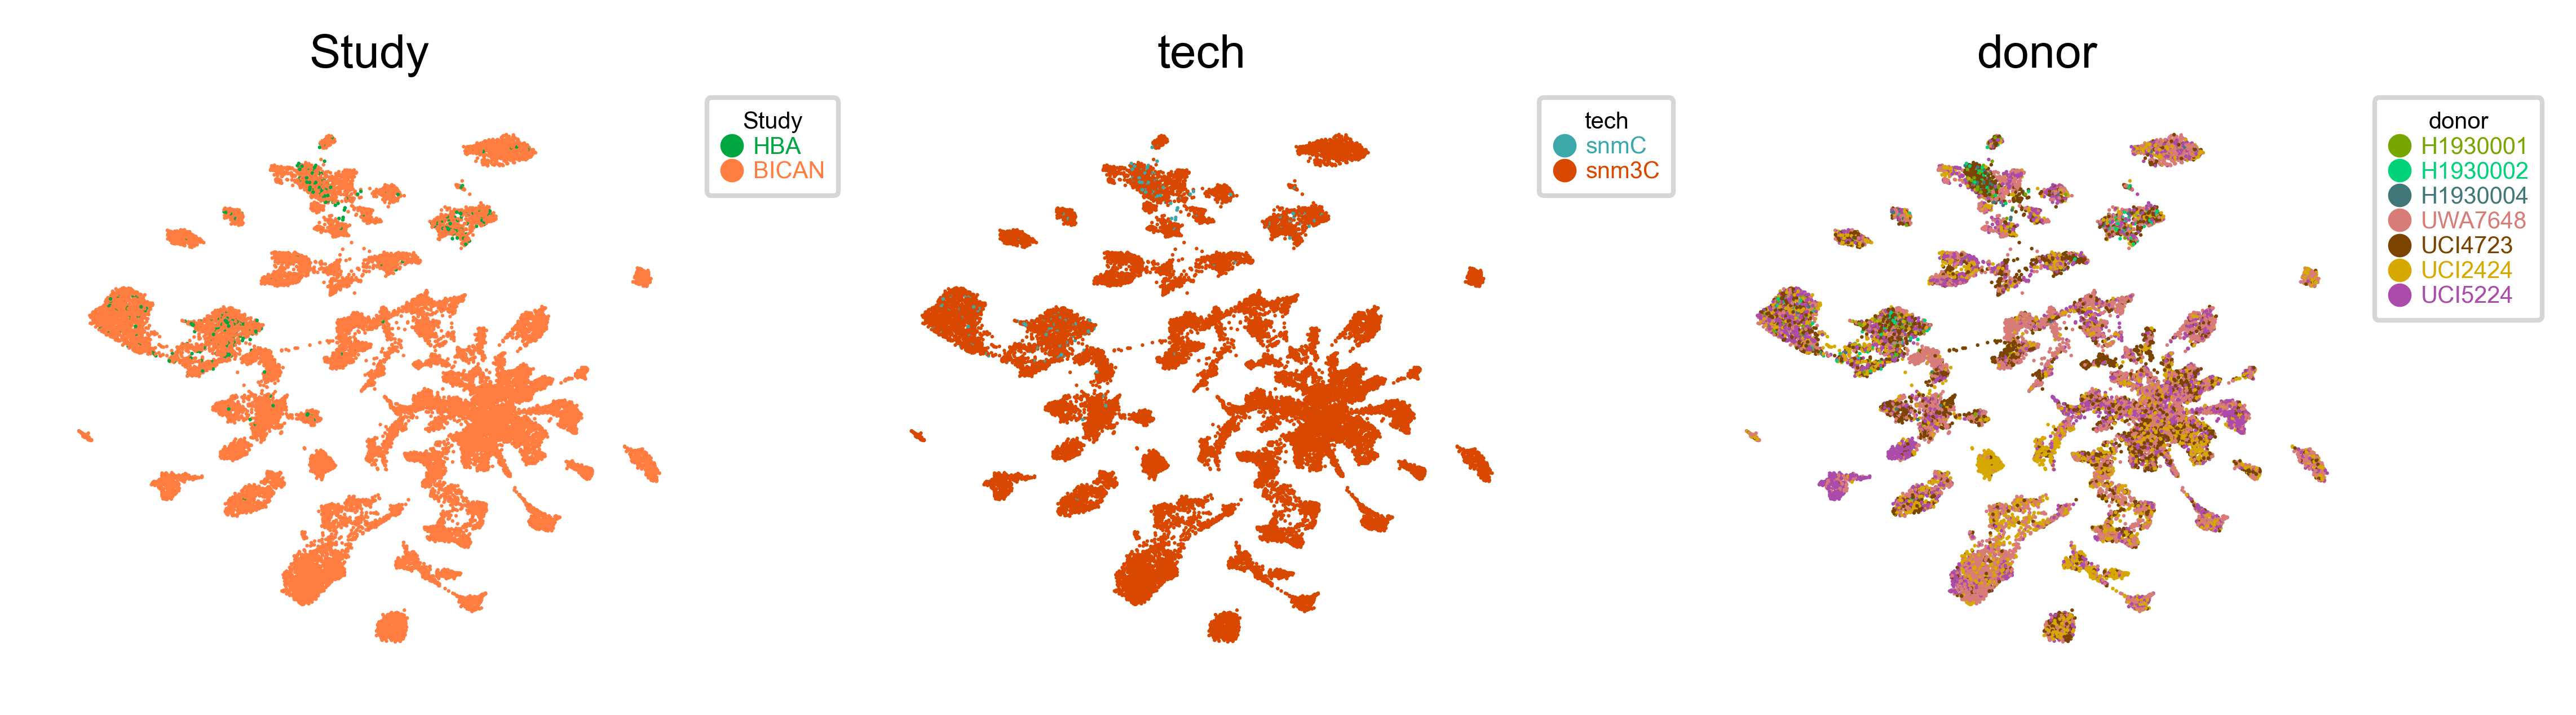

In [46]:
selected_cols=['Study','tech','donor'] #rows
nrows=1
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(ncols * 2.5, nrows * 2), dpi=300,
                         constrained_layout=True,gridspec_kw=dict(wspace=-0.05,hspace=-0.05))
for n,col in enumerate(selected_cols):
    ax=axes[n]
    show_legend = True
    colors=palette_path if col!='L2' else None
    plot_cluster(adata_path=adata,coord_base='umap',cluster_col=col,
         ax=ax,coding=False,palette_path=colors,
         output=None,show_legend=show_legend,legend_fontsize=5,fontsize=6,
        text_anno=None,show=False,axis_format=None,ncol=1)
    ax.set_title(col, fontsize=10)
    # if j==0:
    #     ax.set_ylabel(col, fontsize=10)
    # ax.axis('off')
plt.tight_layout()
plt.savefig(f"{fig_basename}.obs_cols.clustering.pdf", dpi=300, bbox_inches='tight')  #
plt.show()

In [39]:
adata.strings_to_categoricals()
adata.obs.to_csv(f"{data_basename}.obs.tsv",sep='\t')
adata.write_h5ad(f"{data_basename}.annotated.h5ad")